In [1]:
import deepSI
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
from deepSI import System_data, System_data_list

## Data generation

Creating some data for the system

$$
x_{t+1} = a x_t + u_t\\
y_t = x_t
$$

with $a=0.5$

In [2]:
class my_sys(deepSI.System_ss): #a simple state-space wrapper of the general System class
    def __init__(self, a=0.5):
        super(my_sys, self).__init__(nx=1)
        self.a = a
    
    def f(self, x, u):
        return self.a*x + u
    
    def h(self,x):
        return x[0]

a_now = 0.5
sys = my_sys(a=a_now)
data = sys.sample_system(N_sampes=10000) #uniform -1,1 
train, test = data.train_test_split()
train, val = train.train_test_split()
print('train:\t', train)
print('val:\t', val)
print('test:\t', test)

train:	 System_data of length: 5625 nu=None ny=None normed=False dt=None
val:	 System_data of length: 1875 nu=None ny=None normed=False dt=None
test:	 System_data of length: 2500 nu=None ny=None normed=False dt=None


## Creating a custom encoder, $f_\theta$, $g_\theta$ for this sytem.

In [35]:
class my_encoder_net(nn.Module): #a simple FC net with a residual (defaulth appraoch)
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(my_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod(self.ny,dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)

class my_lin_encoder_net(nn.Module): #linear encoder appraoch
    def __init__(self, nb, nu, na, ny, nx, b0=0.5):
        super(my_lin_encoder_net, self).__init__()
        self.b = nn.Parameter(data=torch.as_tensor(b0))

    def forward(self, upast, ypast):
        #first dimention is always the batch dimension (Nb)
        #upast shape: (Nb, nb)
        #ypast shape: (Nb, na)
        return (upast[:,-1] + self.b*ypast[:,-1])[:,None]

class my_state_net(nn.Module): #
    def __init__(self, nx, nu, a0=0.5):
        super(my_state_net, self).__init__()
        self.a = nn.Parameter(data=torch.as_tensor(a0))

    def forward(self, x, u):
        #first dimention is always the batch dimention
        # x shape: (Nb, 1)
        # u shape: (Nb)
        return x*self.a + u[:,None]

class my_output_net(nn.Module):
    def __init__(self, nx, ny):
        super(my_output_net, self).__init__()

    def forward(self, x):
        #first dimention is always the batch dimention
        return x[:,0] #(Nb,nx)

## test if this setup can reproduce the data

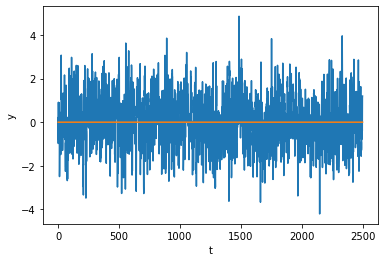

3.2492308559090995e-08

In [16]:

fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, na=1, nb=1, \
                                                e_net=my_lin_encoder_net, e_net_kwargs=dict(b0=a_now),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now),\
                                                h_net=my_output_net)
fit_sys.parameters = fit_sys.init_nets(None,None) #init the network callaed as e_net(**e_net_kwargs) 
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
test_p.NRMS(test) #3.2e-8

# Fitting with linear encoder

In [25]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, e_net=my_lin_encoder_net, e_net_kwargs=dict(b0=a_now*0.9),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now*0.9),\
                                                h_net=my_output_net)
fit_sys.parameters = fit_sys.init_nets(None,None)
fit_sys.use_norm = False #the data should not be normalized
fit_sys.fit(train,epochs=100,sim_val=val, loss_kwargs=dict(nf=25), optimizer_kwargs=dict(betas=(0.99,0.999))) #nf = T in the paper


Size of the training array =  2.9 MB
N_training_samples = 5581, batch_size = 256, N_batch_updates_per_epoch = 21
Initial Validation NRMS= 0.07005444501319882


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### NRMS = 0.041742631692214295
Epoch    1, sqrt loss 0.06501, Val NRMS 0.04174, Time Loss: 53.3%, data: 4.4%, val: 42.4%, 135.5 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.013509404181263316
Epoch    2, sqrt loss 0.03326, Val NRMS 0.01351, Time Loss: 52.1%, data: 4.1%, val: 43.8%, 142.1 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.01109908465320843
Epoch    3, sqrt loss 0.008261, Val NRMS 0.0111, Time Loss: 52.4%, data: 2.9%, val: 44.5%, 148.0 batches/sec
Epoch    4, sqrt loss 0.02228, Val NRMS 0.02593, Time Loss: 48.4%, data: 2.8%, val: 48.7%, 141.0 batches/sec
Epoch    5, sqrt loss  0.0317, Val NRMS 0.02836, Time Loss: 49.0%, data: 3.1%, val: 47.7%, 139.5 batches/sec
Epoch    6, sqrt loss 0.02921, Val NRMS 0.02166, Time Loss: 48.4%, data: 3.5%, val: 47.9%, 142.6 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.010479514210929783

Epoch   69, sqrt loss 4.918e-05, Val NRMS 4.093e-05, Time Loss: 46.3%, data: 3.4%, val: 50.2%, 139.2 batches/sec
Epoch   70, sqrt loss 3.317e-05, Val NRMS 1.008e-05, Time Loss: 46.3%, data: 3.4%, val: 50.2%, 139.1 batches/sec
Epoch   71, sqrt loss 1.367e-05, Val NRMS 2.325e-05, Time Loss: 46.4%, data: 3.4%, val: 50.1%, 139.0 batches/sec
Epoch   72, sqrt loss 3.376e-05, Val NRMS 3.156e-05, Time Loss: 46.3%, data: 3.4%, val: 50.1%, 138.5 batches/sec
Epoch   73, sqrt loss 2.801e-05, Val NRMS 1.264e-05, Time Loss: 46.4%, data: 3.3%, val: 50.1%, 138.4 batches/sec
Epoch   74, sqrt loss 8.679e-06, Val NRMS 1.344e-05, Time Loss: 46.3%, data: 3.3%, val: 50.2%, 138.3 batches/sec
Epoch   75, sqrt loss 2.289e-05, Val NRMS 2.347e-05, Time Loss: 46.5%, data: 3.4%, val: 50.0%, 138.1 batches/sec
Epoch   76, sqrt loss 2.216e-05, Val NRMS 1.184e-05, Time Loss: 46.5%, data: 3.4%, val: 50.0%, 138.1 batches/sec
Epoch   77, sqrt loss 7.036e-06, Val NRMS 7.777e-06, Time Loss: 46.5%, data: 3.4%, val: 50.0%, 1

### Results

a fitted: 0.5000000596046448  real a: 0.5
b fitted: 0.5000050067901611  real b: 0.5


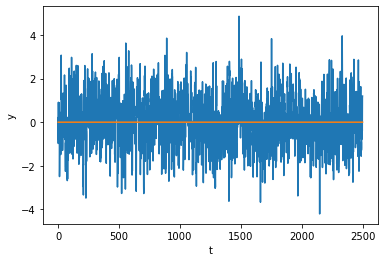

1.0323630514245885e-07

In [29]:
print('a fitted:', fit_sys.fn.a.item(), ' real a:',a_now)
print('b fitted:', fit_sys.encoder.b.item(), ' real b:',a_now)
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
test_p.NRMS(test) #1.0e-7

# Nonlinear encoder

In [30]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, na=2, nb=2,\ #too high na and nb doesn't work well
                                                e_net=my_encoder_net, e_net_kwargs=dict(),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now*0.9),\
                                                h_net=my_output_net)
fit_sys.parameters = fit_sys.init_nets(None,None)
fit_sys.use_norm = False #the data should not be normalized
fit_sys.fit(train,epochs=100,sim_val=val, loss_kwargs=dict(nf=25), optimizer_kwargs=dict(betas=(0.99,0.999))) #nf = T in the paper


Size of the training array =  1.7 MB
N_training_samples = 5599, batch_size = 256, N_batch_updates_per_epoch = 21
Initial Validation NRMS= 0.07474437174340613


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### NRMS = 0.04177938269970573
Epoch    1, sqrt loss   0.208, Val NRMS 0.04178, Time Loss: 59.6%, data: 0.0%, val: 40.4%, 111.8 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.02318095275648027
Epoch    2, sqrt loss  0.1164, Val NRMS 0.02318, Time Loss: 57.2%, data: 1.6%, val: 41.2%, 127.0 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.011119357157307172
Epoch    3, sqrt loss  0.1265, Val NRMS 0.01112, Time Loss: 54.0%, data: 4.2%, val: 41.8%, 128.2 batches/sec
Epoch    4, sqrt loss 0.07131, Val NRMS 0.01517, Time Loss: 54.1%, data: 3.6%, val: 42.3%, 128.8 batches/sec
Epoch    5, sqrt loss 0.09237, Val NRMS 0.01848, Time Loss: 55.0%, data: 3.3%, val: 41.5%, 121.7 batches/sec
Epoch    6, sqrt loss  0.1016, Val NRMS 0.01621, Time Loss: 55.4%, data: 3.0%, val: 41.5%, 118.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.011093494824421546


Epoch   62, sqrt loss 0.01238, Val NRMS 0.001217, Time Loss: 53.7%, data: 2.1%, val: 44.1%, 122.2 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.0009791382270745183
Epoch   63, sqrt loss 0.01173, Val NRMS 0.0009791, Time Loss: 53.6%, data: 2.2%, val: 44.1%, 122.4 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.0008947486411609095
Epoch   64, sqrt loss 0.01157, Val NRMS 0.0008947, Time Loss: 53.7%, data: 2.1%, val: 44.1%, 122.5 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.0008748128905689061
Epoch   65, sqrt loss 0.01114, Val NRMS 0.0008748, Time Loss: 53.7%, data: 2.1%, val: 44.1%, 122.5 batches/sec
Epoch   66, sqrt loss 0.01077, Val NRMS 0.001042, Time Loss: 53.7%, data: 2.1%, val: 44.1%, 122.8 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.0008356508938842426
Epoch   67, sqrt loss 0.01062, Val NRMS 0.0008357, Time Loss: 53.6%, data: 2.2%, val: 44.1%, 12

## Results nonlinear encoder

a fitted: 0.49999818205833435  real a: 0.5


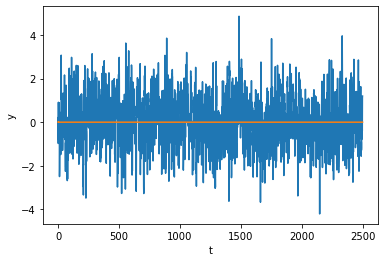

NRMS: 0.00047088984698618415


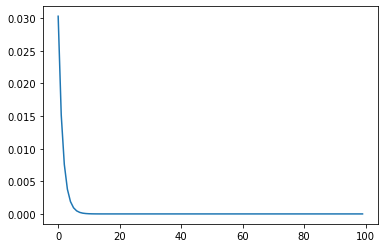

In [34]:
print('a fitted:', fit_sys.fn.a.item(), ' real a:',a_now)
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
print('NRMS:',test_p.NRMS(test)) #1.0e-7
plt.plot(fit_sys.n_step_error(test)) #encoder isn't perfect but it works
plt.show()